# VKYN TensorFlow (EfficientNet)

For B0 to B7 base models, the input shapes are different. Here is a list of input shape expected for each model:

| Base model    | resolution |
|---------------|------------|
| EfficientNetB0 | 224        |
| EfficientNetB1 | 240        |
| EfficientNetB2 | 260        |
| EfficientNetB3 | 300        |
| EfficientNetB4 | 380        |
| EfficientNetB5 | 456        |
| EfficientNetB6 | 528        |
| EfficientNetB7 | 600        |

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from PIL import Image as pil
from PIL.Image import Image
from shutil import move, copy

from vkyn import *

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
tf.get_logger().setLevel("ERROR")

In [6]:
DATA = Path("data/vkyn01-dataset-multi_old")

In [7]:
SEED = 1337

IMAGE_SIZE = (300, 300) # EfficientNetB3
BATCH_SIZE = 128

# Keras will automatically create labels (0 - n, 1 - y)

training_images = tf.keras.utils.image_dataset_from_directory(
    DATA,
    seed = SEED,
    image_size = IMAGE_SIZE,
    validation_split = 0.7,
    batch_size = BATCH_SIZE,
    subset = "training",
    crop_to_aspect_ratio=True,
)
validation_images = tf.keras.utils.image_dataset_from_directory(
    DATA,
    seed = SEED,
    image_size = IMAGE_SIZE,
    validation_split = 0.15,
    batch_size = BATCH_SIZE,
    subset = "validation",
    crop_to_aspect_ratio=True,
)
test_images = tf.keras.utils.image_dataset_from_directory(
    DATA,
    seed = SEED,
    image_size = IMAGE_SIZE,
    validation_split = 0.15,
    batch_size = BATCH_SIZE,
    subset = "validation",
    crop_to_aspect_ratio=True,
)

Found 6170 files belonging to 14 classes.
Using 1851 files for training.
Found 6170 files belonging to 14 classes.
Using 925 files for validation.
Found 6170 files belonging to 14 classes.
Using 925 files for validation.


In [8]:
CLASS_NAMES = training_images.class_names

In [9]:
CLASS_NAMES
len(CLASS_NAMES)

14

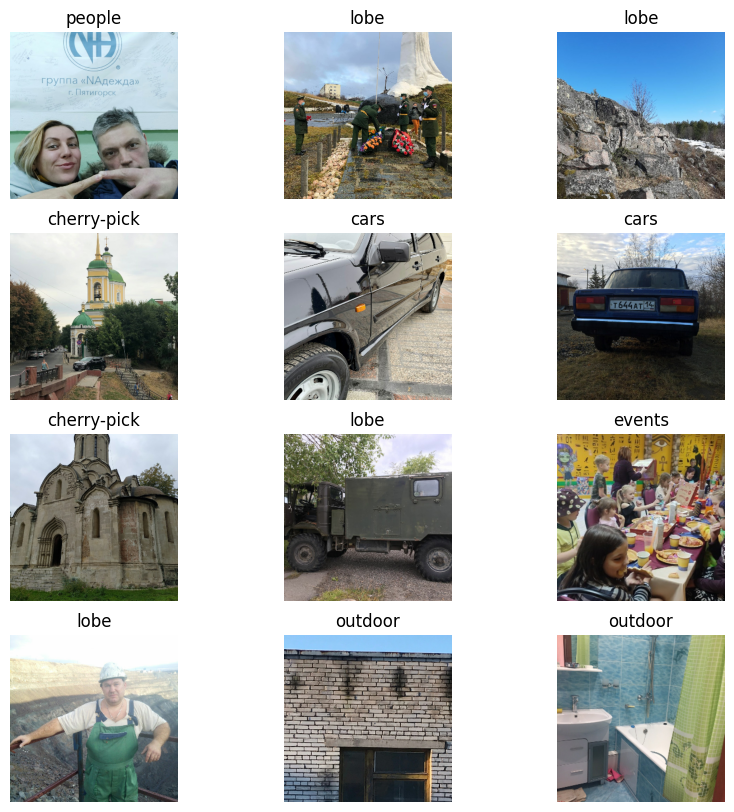

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in training_images.take(1):
    for i in range(12):
        label = training_images.class_names[int(labels[i])]
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label)
        plt.axis("off")

In [11]:
with tf.device("/cpu:0"):
  image_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal", seed=42),
      tf.keras.layers.RandomFlip("vertical", seed=43),
      tf.keras.layers.RandomRotation(0.2, seed=44),
      tf.keras.layers.RandomZoom(0.2, seed=45),
      tf.keras.layers.RandomContrast(0.4, seed=46),
      tf.keras.layers.RandomBrightness(0.3, seed=47),
      tf.keras.layers.RandomTranslation(0.2, 0.2, seed=48),
  ])

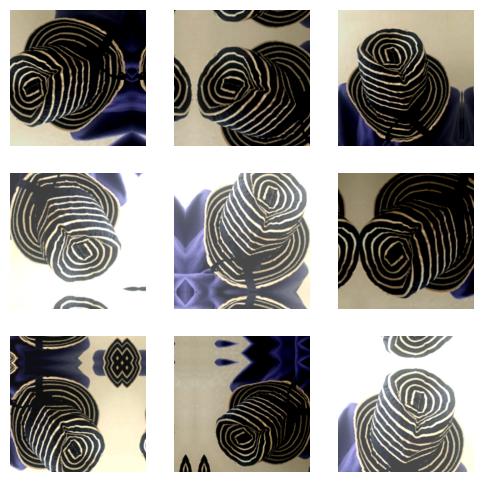

In [12]:
image, label = next(iter(training_images))

plt.figure(figsize=(6, 6))

for i in range(9):
    augmented_image = image_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False, augment_multiplier=3):
  # Resize and rescale all datasets.
  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    # Original dataset
    original_ds = ds

    # Create augmented versions
    augmented_datasets = [original_ds]
    
    # Add multiple augmented versions of the dataset
    for i in range(augment_multiplier - 1):
      aug_ds = original_ds.map(
          lambda x, y: (image_augmentation(x, training=True), y), 
          num_parallel_calls=AUTOTUNE
      )
      augmented_datasets.append(aug_ds)

    # Concatenate all datasets
    ds = augmented_datasets[0]
    for aug_ds in augmented_datasets[1:]:
      ds = ds.concatenate(aug_ds)
    
    # Shuffle again after concatenation
    if shuffle:
      ds = ds.shuffle(1000 * augment_multiplier)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
training_images = prepare(training_images, shuffle=True, augment=True)
validation_images = prepare(validation_images)

In [15]:
def build_model(input_shape, num_classes: int, dropout_rate: float):
    inputs = tf.keras.layers.Input(shape=input_shape)
    cnn = tf.keras.applications.ResNet50(
        input_tensor=inputs,
        include_top=False,
        weights="imagenet",
        classes=13,
    )

    # Freeze the pretrained weights
    cnn.trainable = False

    # Rebuild top
    avg_pool = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(cnn.output)
    x = tf.keras.layers.BatchNormalization()(avg_pool)

    # Dropout
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)

    # Output
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    outputs = tf.keras.layers.Dense(units, activation=activation, name="pred")(x)

    return tf.keras.Model(inputs, outputs, name="VKYN01"), (inputs, cnn, avg_pool, outputs)

In [16]:
# Create an instance of model
model, _ = build_model(
    input_shape=IMAGE_SIZE + (3,),
    # TODO: make the values for the num_classes variable
    num_classes=len(CLASS_NAMES),
    dropout_rate=0.3,
)

In [17]:
# We will save weight of model after each epoch of training in Keras (h5) format.
callbacks = [
    #tf.keras.callbacks.ModelCheckpoint("vkyn01-checkpoints/epoch03_{epoch}.keras"),
    # tf.keras.callbacks.CSVLogger(filename="vkyn01-training.log", separator=",", append=False),
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss",
    #     patience=7,
    #     verbose=1,
    #     # min_delta=0,
    #     # mode="auto",
    #     # baseline=None,
    #     # restore_best_weights=False
    # ),
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss",
    #     factor=0.25,
    #     patience=2,
    #     min_lr=0.0001,
    # ),
    # tf.keras.callbacks.TensorBoard("log_dir/name"),
]

# We unfreeze the top N layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        continue
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # for training head layer

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # for training last 20 layers
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # for training last 20 layers
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0025) # for training last 20 layers

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
# model.summary()

In [18]:
# EPOCHS = 5
EPOCHS = 5
## TODO: the accuracy can still be upgraded by 
# separating the files/getting more train data for the dataset
history = model.fit(
    training_images,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_images,
)

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.0834 - loss: 3.5438 - val_accuracy: 0.1881 - val_loss: 2.5218
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.1714 - loss: 2.9498 - val_accuracy: 0.3492 - val_loss: 2.1948
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.2812 - loss: 2.4997 - val_accuracy: 0.4032 - val_loss: 2.1263
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.3483 - loss: 2.2825 - val_accuracy: 0.4584 - val_loss: 1.9582
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.3597 - loss: 2.2029 - val_accuracy: 0.4822 - val_loss: 1.8696


In [19]:
model.save(f'weights/tf-resnet50_multiclass_{EPOCHS}epoch_dropout04_learningrate1e-4_epochs_temp.keras')
# Epoch 5/5
# 129/129 ━━━━━━━━━━━━━━━━━━━━ 122s 876ms/step - accuracy: 0.9865 - loss: 0.0371 - val_accuracy: 0.9662 - val_loss: 0.0986

# %tensorboard --logdir log_dir/name

In [20]:
%time model.evaluate(test_images)

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4779 - loss: 1.8520
CPU times: total: 8min 2s
Wall time: 23.2 s


[1.8696030378341675, 0.48216214776039124]

In [21]:
def plot_accuracy(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

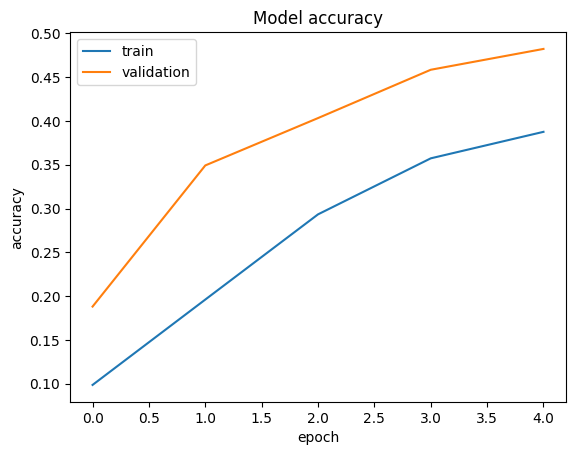

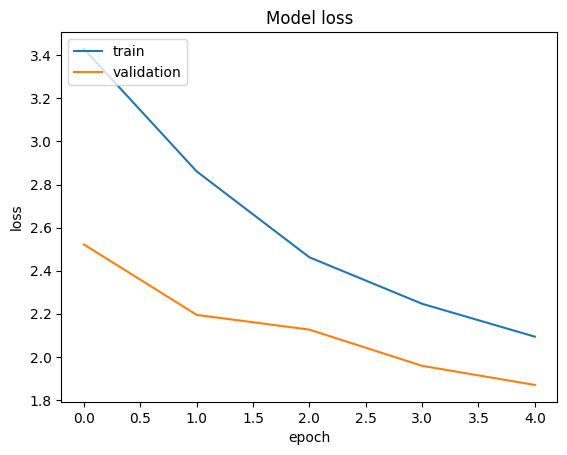

In [22]:
# print("epochs=20; 8k; LR=1e-4; size=384; EfficientNetV2-s ImageNet; with augmentation; dropout=0.25; train last 20 layers")
plot_accuracy(history)
plot_loss(history)

## Validate Model

In [24]:
def process_image(path: Path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

def predict_image(model, path: Path):
    img_array = process_image(path)
    predictions = model.predict(img_array, verbose=1)
    
    # Print raw predictions
    print(predictions[0])
    
    # Get the class with highest probability
    predicted_class_idx = np.argmax(predictions[0])
    predicted_probability = predictions[0][predicted_class_idx]
    
    # If you have class names available (from dataset.class_names)
    # Replace with your actual class names if available
    # class_names = training_images.class_names if hasattr(training_images, 'class_names') else None
    
    result = {
        "class_index": int(predicted_class_idx),
        "probability": float(predicted_probability),
        "class_name": CLASS_NAMES[predicted_class_idx]
    }
    
    # # Add class name if available
    # if class_names:
    #     result["class_name"] = CLASS_NAMES[predicted_class_idx]
        
    return result

In [29]:
# # Create an instance of model
# model, _ = build_model(
#     input_shape=IMAGE_SIZE + (3,),
#     # TODO: make the values for the num_classes variable
#     num_classes=13,
#     dropout_rate=0.3,
# )

In [58]:
# model.load_weights("./weights/tf-efficientnetb5_multiclass_50epoch_dropout04_learningrate1e-4_epochs.keras")

{'y': np.float32(0.34424585), 'n': np.float32(0.65575415)}

In [25]:
exampleImages = ["./data/vaska_clean/-486_359189381.jpg", "./data/vaska_clean/34942_456240674.jpg"]

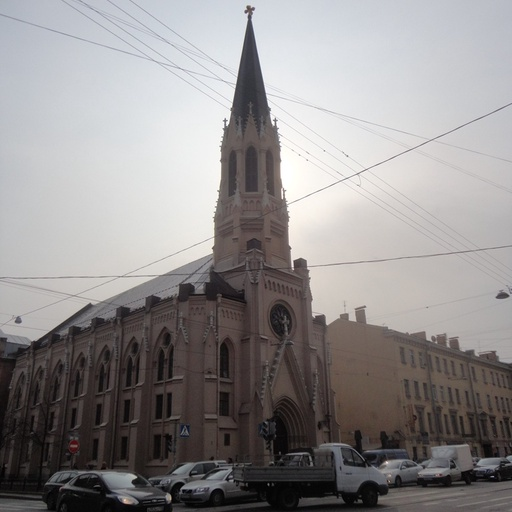

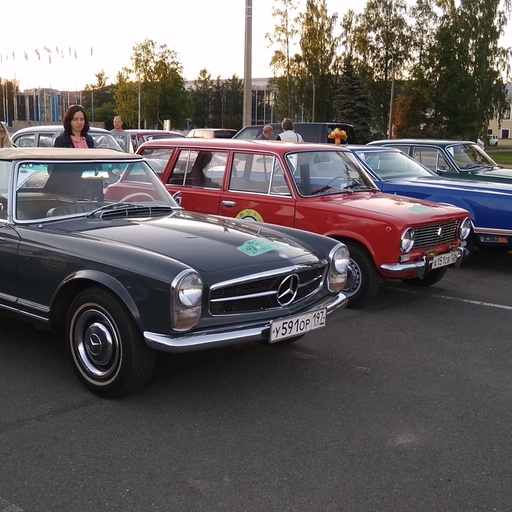

In [26]:
from IPython.display import Image
for n in exampleImages:
    display(Image(filename=n))

In [87]:
for n in exampleImages:
    print(predict_image(model, Path(n)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[3.78445024e-03 8.79205987e-02 5.80217123e-01 3.97947617e-03
 1.26203345e-02 2.62371800e-03 1.15731475e-03 3.12304730e-03
 2.76886821e-01 3.44858901e-03 1.98037873e-04 2.15345323e-02
 2.50597694e-03]
{'class_index': 2, 'probability': 0.5802171230316162, 'class_name': 'city'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
[1.2937711e-03 4.2618979e-03 3.4161173e-03 1.4774554e-03 3.1912210e-03
 4.8514982e-03 7.2477281e-04 2.1693236e-03 6.5141346e-04 1.4398408e-03
 2.4109449e-04 9.7319984e-01 3.0816873e-03]
{'class_index': 11, 'probability': 0.9731998443603516, 'class_name': 'transport'}
